# Analyse der Bordkarten-kontrolldaten des BERs
Ein Studentenprojekt an der<br>
<img src="https://upload.wikimedia.org/wikipedia/de/thumb/9/90/Hochschule_f%C3%BCr_Wirtschaft_und_Recht_Berlin_logo.svg/500px-Hochschule_f%C3%BCr_Wirtschaft_und_Recht_Berlin_logo.svg.png?20090401201013" width="240" align="left" style="display:block;clear:both;"/>
<br><br><br><br>
Hochschule für Wirtschaft und Recht Berlin<br>
Fachbereich II - Duales Studium Wirtschaft / Technik<br>
<i>Modul: Business Intelligence (WI-201)</i>

<b>Repository</b> (inklusive <b>Voraussetzungen</b> und <b>Installationsanleitung</b>):<br>
https://github.com/italyboy2012/bi-project

## Importe

> Ziel dieses Schrittes ist es, die notwendigen Pakete zu importieren

In [1]:
# Import Datenbank-Konfiguration
#########################################
import dbCredentials
#print(dbCredentials.host)
#print(dbCredentials.username)
#print(dbCredentials.password)

# Import Libs
#########################################
from sqlalchemy import create_engine
import mysql.connector
from mysql.connector import errorcode
from sqlalchemy import MetaData
from sqlalchemy_schemadisplay import create_schema_graph

#########################################
# Sollten diese nicht installiert sein, dann einmalig folgende Befehle über die Eingabeaufforderung ausführen
    # !pip install mysql-connector-python
    # !pip install SQLAlchemy
    # !pip install PyMySQL
    # !pip install sqlalchemy_schemadisplay
    # (mehr Informationen zum 1. Befehl, MySQL-Connector: https://dev.mysql.com/doc/connector-python/en/connector-python-introduction.html )
    # (mehr Informationen zum 2. Befehl, SQLAlchemy: https://docs.sqlalchemy.org/en/14/index.html )
    
#########################################
from hilfsfunktionen import *
import pandas as pd
from IPython.display import display_html

## Datenbank für Daten aus operativen Quellsystemen anlegen

>Ziel dieses Schritts ist es, eine Datenkank für die Daten aus den operativen Quellsystemen (angereichert mit öffentlich zugänglichen Daten) zu erstellen.<br><br>
Stelle sicher, dass der lokale MySQL Server gestartet wurde.

In [2]:
connection = create_server_connection(dbCredentials.host, dbCredentials.username, dbCredentials.password)

db_name = 'biProjekt_Quelldaten'

# Falls bereits eine Datenbank mit dem in der Variable db_name definierten Namen existiert, wird sie mit diesem Befehl gelöscht:
create_database_query = "DROP DATABASE IF EXISTS " + db_name + ";"
create_database(connection, create_database_query)

# Erstellen der Datenbank mit dem in der Variable db_name definierten Namen
create_database_query = "CREATE DATABASE " + db_name + ";"
create_database(connection, create_database_query)


db_connection_str = 'mysql+pymysql://' + dbCredentials.username + ':' + dbCredentials.password + '@' + dbCredentials.host + '/' + db_name
db_connection = create_engine(db_connection_str)

MySQL Database connection successful
Database created successfully
Database created successfully


## Daten der operativen Quellsysteme in die Datenbank laden

> Ziel dieses Schritts ist es die Daten aus den operativen Quellsystemen (angereichert mit öffentlich zugänglichen Daten) aus den CSV-Dateien in die im vorherigen Schritt angelegte Datenbank zu laden.

In [3]:
# Daten aus den CSV-Dateien in die DataFrames laden
df_bkk = pd.read_csv("data/bkk-data.csv", sep=";")
df_spos = pd.read_csv("data/scanningPositions.csv", sep=";", decimal=".")
df_covid = pd.read_csv("data/covid19_cases.csv", sep=",")
df_airports = pd.read_csv("data/airports.csv", sep=",")
df_gdp = pd.read_csv("data/GDP.csv", sep=",")

# Daten aus den DataFrames in die Datenbank laden
df_bkk.to_sql(con=db_connection, name='BKK', if_exists='replace')
df_spos.to_sql(con=db_connection, name='ScanningPositions', if_exists='replace')
df_covid.to_sql(con=db_connection, name='Covid19', if_exists='replace')
df_airports.to_sql(con=db_connection, name='Airports', if_exists='replace')
df_gdp.to_sql(con=db_connection, name='GDP', if_exists='replace')

## Stichprobenartige Auswahl zur Testung des Imports

> Ziel dieses Schrittes ist es, die soeben in die Datenbank geladene CSV-Dateien testweise auszugenen.

In [4]:
df_airports = pd.read_sql('Select * FROM Airports;', index_col='index', con=db_connection)
df_airports.head()

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords
index,,,,,,,,,,,,,,,,,,
0,6523,00A,heliport,Total Rf Heliport,40.070801,-74.933601,11.0,None,US,US-PA,Bensalem,no,00A,None,00A,None,None,None
1,323361,00AA,small_airport,Aero B Ranch Airport,38.704022,-101.473911,3435.0,None,US,US-KS,Leoti,no,00AA,None,00AA,None,None,None
2,6524,00AK,small_airport,Lowell Field,59.947733,-151.692524,450.0,None,US,US-AK,Anchor Point,no,00AK,None,00AK,None,None,None
3,6525,00AL,small_airport,Epps Airpark,34.864799,-86.770302,820.0,None,US,US-AL,Harvest,no,00AL,None,00AL,None,None,None
4,6526,00AR,closed,Newport Hospital & Clinic Heliport,35.608700,-91.254898,237.0,None,US,US-AR,Newport,no,None,None,None,None,None,00AR


In [5]:
df_spos = pd.read_sql('Select * FROM ScanningPositions;', index_col='index', con=db_connection)
df_spos.head()

,ScanningPosition,Siko,latitude_spos,longitude_spos
index,,,,
0,BKK 1.1,1.0,52.365253,13.507102
1,BKK 1.2,1.0,52.365253,13.507102
2,BKK 1.3 PRM,1.0,52.365253,13.507102
3,BKK 2.1,2.0,52.364360,13.506767
4,BKK 2.2,2.0,52.364360,13.506767


In [6]:
df_bkk = pd.read_sql('Select * FROM BKK;', index_col='index', con=db_connection)
df_bkk.head()

,TimeStamp,Terminal,ScanningPosition,Destination,TravelDate,Evaluation,STD,DocumentType
index,,,,,,,,
0,01.01.22 04:42,T1,BKK 1.2,None,None,Rejected,None,Unknown
1,01.01.22 04:53,T1,DTC PAV Nord,None,None,Rejected,None,Unknown
2,01.01.22 04:59,T1,BKK 4.4,None,None,Rejected,None,Unknown
3,01.01.22 05:03,T1,BKK 2.3,None,None,Rejected,None,Unknown
4,01.01.22 05:14,T1,BKK 2.4,None,None,Rejected,None,Unknown


In [7]:
df_beispiel = pd.read_sql('Select * FROM BKK'+
                            ' JOIN Airports on BKK.Destination = Airports.iata_code'+
                            ' Order By Airports.iata_code;', index_col=None, con=db_connection)

df_beispiel.head()

,index,TimeStamp,Terminal,ScanningPosition,Destination,TravelDate,Evaluation,STD,DocumentType,index,...,iso_country,iso_region,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords
0,48107,03.01.22 11:51,T1,BKK 3.2 Fastlane,AAQ,03.01.22,Rejected,None,PDF417,59632,...,RU,RU-KDA,Anapa,yes,URKA,AAQ,None,http://basel.aero/en/anapa/,https://en.wikipedia.org/wiki/Anapa_Airport,Vityazevo Airport
1,14778,01.01.22 14:40,T1,BKK 4.4,ABA,02.01.22,Rejected,None,PDF417,59570,...,RU,RU-KK,Abakan,yes,UNAA,ABA,None,None,https://en.wikipedia.org/wiki/Abakan_Internati...,None
2,81203,06.01.22 07:00,T1,BKK 2.3,ABJ,06.01.22,Rejected,None,PDF417,20381,...,CI,CI-01,Abidjan,yes,DIAP,ABJ,None,None,https://en.wikipedia.org/wiki/F%C3%A9lix-Houph...,"Abidjan, Port Bouët"
3,66868,04.01.22 17:25,T1,DTC Nord 2,ABV,05.01.22,Rejected,00:00,PDF417,20471,...,NG,NG-FC,Abuja,yes,DNAA,ABV,None,http://www.faannigeria.org/nigeria-airport.php...,https://en.wikipedia.org/wiki/Nnamdi_Azikiwe_I...,None
4,66862,04.01.22 17:24,T1,BKK 2.4,ABV,05.01.22,Rejected,None,PDF417,20471,...,NG,NG-FC,Abuja,yes,DNAA,ABV,None,http://www.faannigeria.org/nigeria-airport.php...,https://en.wikipedia.org/wiki/Nnamdi_Azikiwe_I...,None


## Normalisierung

> Die soeben importierten Daten liegen in der nullten Normalform vor.<br>
Ziel dieses Schritts ist es, diese Daten in die dritte Normalform zu überführen.

In [8]:
# kann übersprungen werden

## Verknüpfen der importierten Tabellen

> Ziel dieses Schritts ist es, die sich in der Datenbank befindlichen Daten in eine einzige Datenbanktabelle zu überführen. Dies erleichtert es in einem zukünftigen Schritt ein Sternschema zu erstellen.

>Die Umsetzung erfolgte mittels Tableau Prep Builder. Die Ausgabe wurde ein eine neue Datenbank-Tabelle namens "joined_data" geschrieben. Die Tableau-Datei kann unter dem Pfad "tableau/20220330.1 joined_data.tfl" gefunden werden.

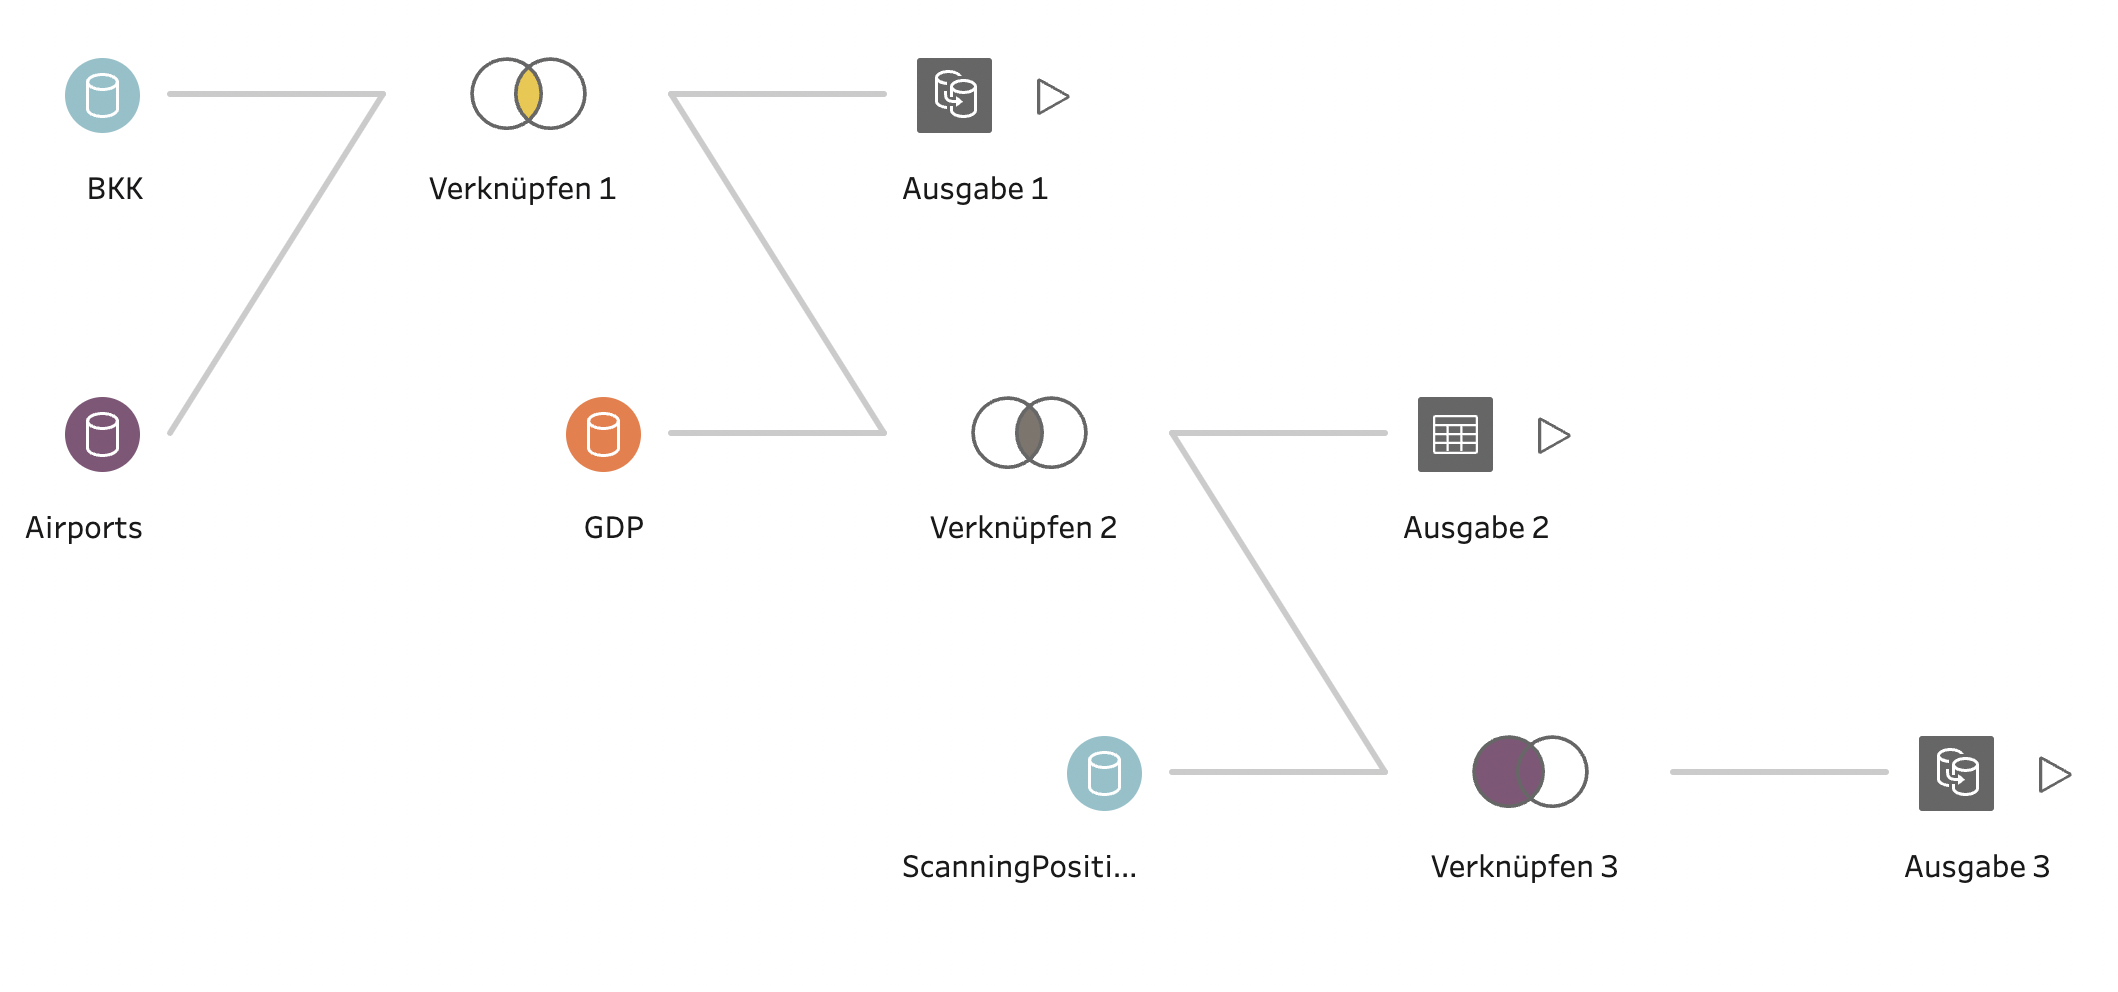

> Bitte stelle sicher, dass die "Ausgabe 3" der Datei "tableau/20220330.1 joined_data.tfl" über Tableau Prep Builder ausgeführt wurde.

In [9]:
df_joinedData = pd.read_sql('Select * FROM joined_data', index_col='index', con=db_connection)
df_joinedData.to_csv("data/export_Daten.csv", sep=";", decimal=".")
df_joinedData.head()

,GDP (UN),STD,keywords,ident,municipality,type,GDP (IMF),Density,latitude_spos,Subregion,...,Government,TravelDate,home_link,DocumentType,local_code,Terminal,longitude_spos,2020 Population Rank,2020 World Percentage,Siko
index,,,,,,,,,,,,,,,,,,,,,
5869,$204.84 Bn,06:00,Lisboa,LPPT,Lisbon,large_airport,$249.91 Bn,110.73,52.36436,Southern Europe,...,Portugal,01.01.22,http://www.ana.pt/en-US/Aeroportos/lisboa/Lisb...,Aztec,None,T1,13.506767,89,0.13%,2.0
5874,$204.84 Bn,06:00,Lisboa,LPPT,Lisbon,large_airport,$249.91 Bn,110.73,52.36436,Southern Europe,...,Portugal,01.01.22,http://www.ana.pt/en-US/Aeroportos/lisboa/Lisb...,PDF417,None,T1,13.506767,89,0.13%,2.0
5883,$93.27 Bn,06:55,"Borispol, Міжнародний аеропорт ""Бориспіль""",UKBB,Kiev,large_airport,$147.17 Bn,72.47,52.36436,Eastern Europe,...,Ukraine,01.01.22,http://www.airport-borispol.kiev.ua/,Aztec,None,T1,13.506767,35,0.56%,2.0
5884,$93.27 Bn,06:55,"Borispol, Міжнародний аеропорт ""Бориспіль""",UKBB,Kiev,large_airport,$147.17 Bn,72.47,52.36436,Eastern Europe,...,Ukraine,01.01.22,http://www.airport-borispol.kiev.ua/,Aztec,None,T1,13.506767,35,0.56%,2.0
5893,$93.27 Bn,06:55,"Borispol, Міжнародний аеропорт ""Бориспіль""",UKBB,Kiev,large_airport,$147.17 Bn,72.47,52.36436,Eastern Europe,...,Ukraine,01.01.22,http://www.airport-borispol.kiev.ua/,PDF417,None,T1,13.506767,35,0.56%,2.0


## Erstellen des Sternschemas

> Ziel dieses Schritts ist es, die soeben erstellte Tabelle "joined_data" in ein analyseorientiertes OLAT-Sternschema zu überführen.

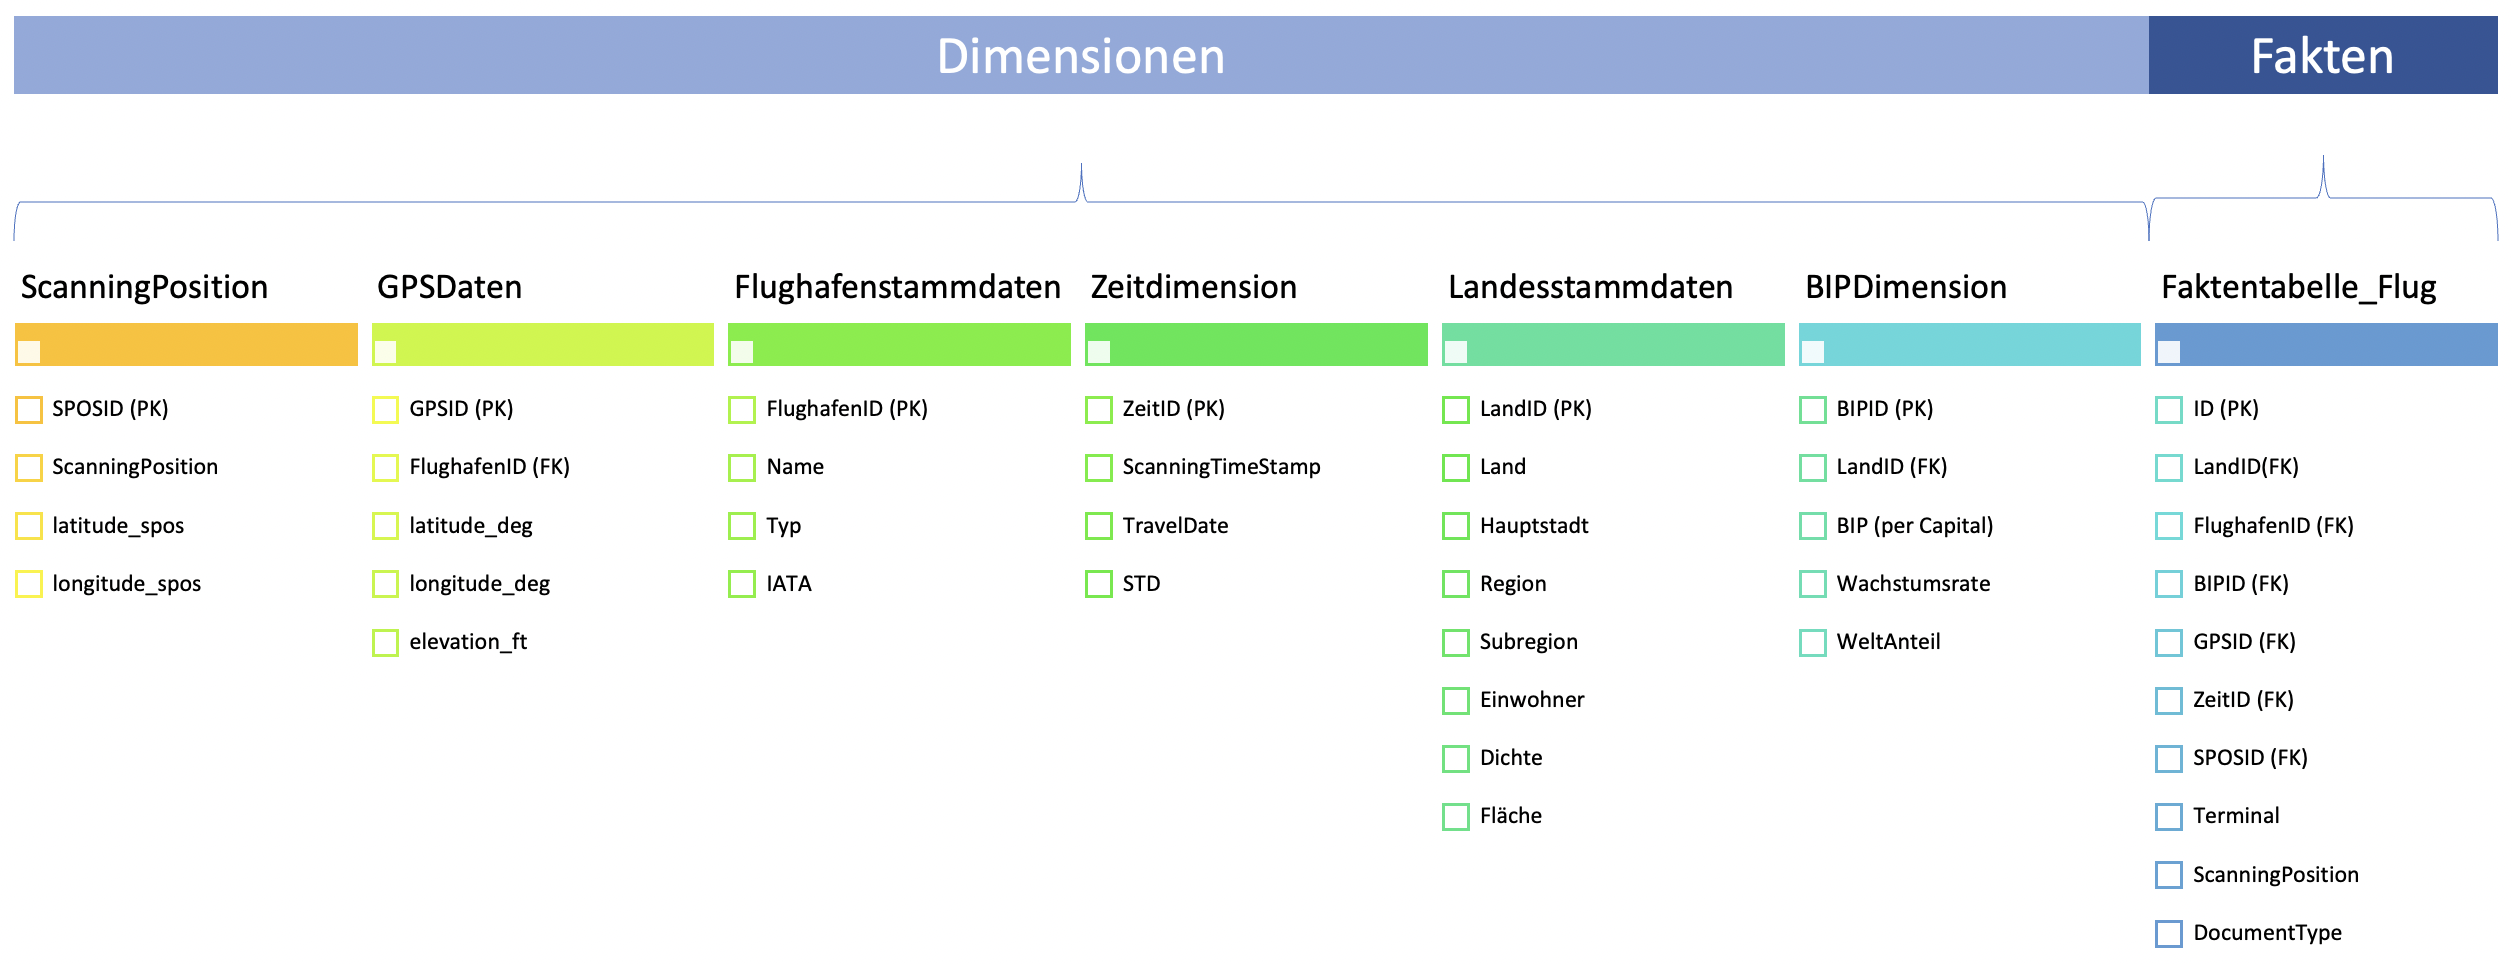

In [10]:
'''
####################################
PK = Primary Key (Primärschlüssel)
FK = Foreign Key (Fremdschlüssel)
####################################

########Dimensionstabellen:#########

GPSDaten:
        GPSID (PK),
        FlughafenID (FK),
        latitude_deg,
        longitude_deg,
        elevation_ft,
        
Flughafenstammdaten: 
        FlughafenID (PK), 
        Name, 
        Typ,
        IATA,

Zeitdimension: 
        ZeitID (PK),
        ScanningTimeStamp,
        TravelDate,
        STD,
        
Landesstammdaten:  
        LandID (PK)
        Land,
        Hauptstadt,
        Region
        Subregion,
        Einwohner,
        Dichte,
        Fläche,
        
BIPDimension:
        BIPID (PK),
        LandID (FK),
        BIP (per Capital),
        Wachstumsrate,
        WeltAnteil,
        
ScanningPosition:
        SPOSID (PK),
        ScanningPosition,
        latitude_spos,
        longitude_spos,

##########Faktentabelle:#############

Faktentabelle_Flug
        ID (PK),
        LandID(FK von Dimensionstabelle XX),
        FlughafenID (FK),
        BIPID (FK),
        GPSID (FK),
        ZeitID (FK),
        SPOSID (FK),
        Terminal,
        ScanningPosition,
        DocumentType,
'''

'\n####################################\nPK = Primary Key (Primärschlüssel)\nFK = Foreign Key (Fremdschlüssel)\n####################################\n\n########Dimensionstabellen:#########\n\nGPSDaten:\n        GPSID (PK),\n        FlughafenID (FK),\n        latitude_deg,\n        longitude_deg,\n        elevation_ft,\n        \nFlughafenstammdaten: \n        FlughafenID (PK), \n        Name, \n        Typ,\n        IATA,\n\nZeitdimension: \n        ZeitID (PK),\n        ScanningTimeStamp,\n        TravelDate,\n        STD,\n        \nLandesstammdaten:  \n        LandID (PK)\n        Land,\n        Hauptstadt,\n        Region\n        Subregion,\n        Einwohner,\n        Dichte,\n        Fläche,\n        \nBIPDimension:\n        BIPID (PK),\n        LandID (FK),\n        BIP (per Capital),\n        Wachstumsrate,\n        WeltAnteil,\n        \nScanningPosition:\n        SPOSID (PK),\n        ScanningPosition,\n        latitude_spos,\n        longitude_spos,\n\n##########Faktentabel

In [11]:
df_GPSDaten = pd.read_sql('SELECT jd.id AS GPSID, jd.id AS FlughafenID, jd.latitude_deg, jd.longitude_deg, jd.elevation_ft FROM joined_data AS jd;', con=db_connection)
df_GPSDaten.drop_duplicates(inplace=True)
df_GPSDaten.set_index("GPSID", inplace=True)
df_GPSDaten.head()

,FlughafenID,latitude_deg,longitude_deg,elevation_ft
GPSID,,,,
4461,4461,38.781300,-9.135920,374.0
6467,6467,50.345001,30.894699,427.0
4185,4185,49.012798,2.550000,392.0
2513,2513,52.308601,4.763890,-11.0
301881,301881,52.351389,13.493889,157.0


In [12]:
df_Flughafenstammdaten = pd.read_sql('SELECT jd.id AS FlughafenID, jd.name, jd.type, jd.iata_code FROM joined_data AS jd;', con=db_connection)
df_Flughafenstammdaten.drop_duplicates(inplace=True)
df_Flughafenstammdaten.set_index("FlughafenID", inplace=True)
df_Flughafenstammdaten.head()

,name,type,iata_code
FlughafenID,,,
4461,Humberto Delgado Airport (Lisbon Portela Airport),large_airport,LIS
6467,Boryspil International Airport,large_airport,KBP
4185,Charles de Gaulle International Airport,large_airport,CDG
2513,Amsterdam Airport Schiphol,large_airport,AMS
301881,Berlin Brandenburg Airport,large_airport,BER


In [13]:
df_Zeitdimension = pd.read_sql('SELECT jd.id AS ZeitID, jd.TimeStamp As ScanningTimeStamp, jd.TravelDate, jd.STD FROM joined_data AS jd;', con=db_connection)
df_Zeitdimension.drop_duplicates(inplace=True)
df_Zeitdimension.set_index("ZeitID", inplace=True)
df_Zeitdimension.head()

,ScanningTimeStamp,TravelDate,STD
ZeitID,,,
4461,01.01.22 03:41,01.01.22,06:00
4461,01.01.22 03:45,01.01.22,06:00
6467,01.01.22 03:49,01.01.22,06:55
6467,01.01.22 03:53,01.01.22,06:55
4185,01.01.22 03:54,01.01.22,07:20


In [14]:
df_Landesstammdaten = pd.read_sql('SELECT jd.id AS LandID, jd.Country AS Land, jd.`Capital City` AS Hauptstadt, jd.Region, jd.Subregion, jd.`Population Rank`, jd.Density AS Dichte, jd.Area AS `Fläche` FROM joined_data AS jd;', con=db_connection)
df_Landesstammdaten.drop_duplicates(inplace=True)
df_Landesstammdaten.set_index("LandID", inplace=True)
df_Landesstammdaten.head()

,Land,Hauptstadt,Region,Subregion,Population Rank,Dichte,Fläche
LandID,,,,,,,
4461,Portugal,Lisbon,Europe,Southern Europe,89.0,110.73,"92,090"
6467,Ukraine,Kiev,Europe,Eastern Europe,35.0,72.47,"603,500"
4185,France,Paris,Europe,Western Europe,22.0,118.31,"551,695"
2513,Netherlands,Amsterdam,Europe,Western Europe,69.0,409.44,"41,850"
301881,Germany,Berlin,Europe,Western Europe,19.0,234.61,"357,114"


In [15]:
df_BIPDimension = pd.read_sql('SELECT jd.id AS BIPID, jd.id AS LandID, jd.`GDP Per Capita` AS `BIP pro Einw.`, jd.`Growth Rate` AS Wachstumsrate, jd.`World Percentage` AS WeltAnteil FROM joined_data AS jd;', con=db_connection)
df_BIPDimension.drop_duplicates(inplace=True)
df_BIPDimension.set_index("BIPID", inplace=True)
df_BIPDimension.head()

,LandID,BIP pro Einw.,Wachstumsrate,WeltAnteil
BIPID,,,,
4461,4461,"$24,509.08",-0.29%,0.13%
6467,6467,"$3,365.13",-0.59%,0.56%
4185,4185,"$44,061.52",0.22%,0.84%
2513,2513,"$55,730.27",0.22%,0.22%
301881,301881,"$49,617.15",0.32%,1.07%


In [16]:
df_SPOSDimension = pd.read_sql('SELECT jd.id AS SPOSID, jd.ScanningPosition AS ScanningPosition, jd.Siko AS Siko, jd.`latitude_spos` AS `latitude_spos`, jd.`longitude_spos` AS `longitude_spos` FROM joined_data AS jd;', con=db_connection)
df_SPOSDimension.set_index("SPOSID", inplace=True)

#jd.Siko AS Siko, 

# ScanningPositions ohne Koordinaten löschen (wo wir nicht wissen, wo sich diese am BER befinden)
df_SPOSDimension.dropna(inplace=True, axis=0, how='any')
df_SPOSDimension.drop_duplicates(inplace=True)

df_SPOSDimension

,ScanningPosition,Siko,latitude_spos,longitude_spos
SPOSID,,,,
4461,BKK 2.4,2.0,52.364360,13.506767
4461,BKK 2.3,2.0,52.364360,13.506767
4185,BKK 2.2,2.0,52.364360,13.506767
4251,BKK 2.1,2.0,52.364360,13.506767
2513,BKK 4.4,4.0,52.363282,13.507494
4461,BKK 1.1,1.0,52.365253,13.507102
4185,BKK 4.5,4.0,52.363282,13.507494
4185,BKK 4.6,4.0,52.363282,13.507494
2429,BKK 1.3 PRM,1.0,52.365253,13.507102


In [17]:
df_FaktentabelleFlug = pd.read_sql('SELECT jd.id AS LandID, jd.id AS FlughafenID, jd.id AS BIPID, jd.id AS GPSID, jd.id AS ZeitID, jd.id AS SPOSID, jd.Terminal, jd.ScanningPosition, jd.DocumentType FROM joined_data AS jd;', con=db_connection)
# df_FaktentabelleFlug.drop_duplicates(inplace=True)
# df_FaktentabelleFlug.set_index("ID", inplace=True)
df_FaktentabelleFlug.head()

,LandID,FlughafenID,BIPID,GPSID,ZeitID,SPOSID,Terminal,ScanningPosition,DocumentType
0,4461,4461,4461,4461,4461,4461,T1,BKK 2.4,Aztec
1,4461,4461,4461,4461,4461,4461,T1,BKK 2.3,PDF417
2,6467,6467,6467,6467,6467,6467,T1,BKK 2.4,Aztec
3,6467,6467,6467,6467,6467,6467,T1,BKK 2.4,Aztec
4,6467,6467,6467,6467,6467,6467,T1,BKK 2.4,PDF417


## Erstellen einer OLAP-Datenbank

> Ziel dieses Schrittes ist es eine OLAP-Datenbank zu erstellen, um im nachfolgenden Schritt die Fakten- und Dimensionstabelle(n) in diese zu schreiben.

In [26]:
db_name = 'biProjekt_OLAP'

create_database_query = "DROP DATABASE IF EXISTS " + db_name + ";"
create_database(connection, create_database_query)

create_database_query = "CREATE DATABASE " + db_name + ";"
create_database(connection, create_database_query)

Database created successfully
Database created successfully


## Schreiben der Fakten- und Dimensionstabelle(n)

> Ziel dieses Schrittes ist es die Fakten- und Dimensionstabelle(n) in die OLAP-Datenbank zu schreiben.

In [27]:
db_connection_str = 'mysql+pymysql://' + dbCredentials.username + ':' + dbCredentials.password + '@' + dbCredentials.host + '/' + db_name
db_connection = create_engine(db_connection_str)

df_GPSDaten.to_sql(con=db_connection, name='GPSDaten', if_exists='replace')
df_Flughafenstammdaten.to_sql(con=db_connection, name='Flughafenstammdaten', if_exists='replace')
df_Zeitdimension.to_sql(con=db_connection, name='Zeitdimension', if_exists='replace')
df_Landesstammdaten.to_sql(con=db_connection, name='Landesstammdaten', if_exists='replace')
df_BIPDimension.to_sql(con=db_connection, name='BIPDimension', if_exists='replace')
df_SPOSDimension.to_sql(con=db_connection, name='ScanningPosition', if_exists='replace')
df_FaktentabelleFlug.to_sql(con=db_connection, name='FaktentabelleFlug', if_exists='replace')

In [28]:
# Schlüsselbeziehungen zwischen den Tabellen erstellen
# Fehlermeldungen bzgl. Foreign Key: https://stackoverflow.com/questions/21659691/error-1452-cannot-add-or-update-a-child-row-a-foreign-key-constraint-fails
query_table_relations = """
ALTER TABLE `FaktentabelleFlug` MODIFY `index` BIGINT;
ALTER TABLE `FaktentabelleFlug` MODIFY `LandID` BIGINT;
ALTER TABLE `FaktentabelleFlug` MODIFY `FlughafenID` BIGINT;
ALTER TABLE `FaktentabelleFlug` MODIFY `BIPID` BIGINT;
ALTER TABLE `FaktentabelleFlug` MODIFY `GPSID` BIGINT;
ALTER TABLE `FaktentabelleFlug` MODIFY `SPOSID` BIGINT;

SET FOREIGN_KEY_CHECKS=0;

ALTER TABLE `FaktentabelleFlug` ADD CONSTRAINT `FaktentabelleFlug_Land Id_fk` FOREIGN KEY (`LandID`) REFERENCES `Landesstammdaten`(`LandID`);
ALTER TABLE `FaktentabelleFlug` ADD CONSTRAINT `FaktentabelleFlug_Flug Id_fk` FOREIGN KEY (`FlughafenID`) REFERENCES `Flughafenstammdaten`(`FlughafenID`);
ALTER TABLE `FaktentabelleFlug` ADD CONSTRAINT `FaktentabelleFlug_BIP Id_fk` FOREIGN KEY (`BIPID`) REFERENCES `BIPDimension`(`BIPID`);
ALTER TABLE `FaktentabelleFlug` ADD CONSTRAINT `FaktentabelleFlug_GPS Id_fk` FOREIGN KEY (`GPSID`) REFERENCES `GPSDaten`(`GPSID`);
ALTER TABLE `FaktentabelleFlug` ADD CONSTRAINT `FaktentabelleFlug_Zeit Id_fk` FOREIGN KEY (`ZeitID`) REFERENCES `Zeitdimension`(`ZeitID`);
ALTER TABLE `FaktentabelleFlug` ADD CONSTRAINT `FaktentabelleFlug_SPOS Id_fk` FOREIGN KEY (`SPOSID`) REFERENCES `ScanningPosition`(`SPOSID`);
"""

# Connect to the Database
connection = create_db_connection(dbCredentials.host, dbCredentials.username, dbCredentials.password, db_name)
execute_query(connection, query_table_relations)

MySQL Database connection successful
Query successful


## Erstellen des ER-Modells

> Ziel dieses Schrittes ist es ein ER-Modell der OLAP-Datenbank zu erzeugen.

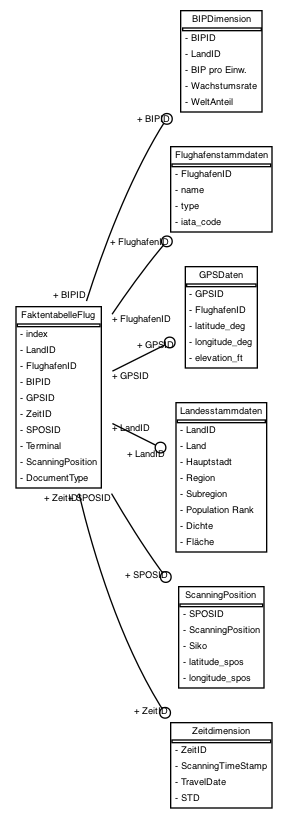

In [29]:
db_connection_str = 'mysql+pymysql://' + dbCredentials.username + ':' + dbCredentials.password + '@' + dbCredentials.host + '/' + db_name
# create the pydot graph object by autoloading all tables via a bound metadata object
graph = create_schema_graph(metadata=MetaData(db_connection_str),
   show_datatypes=False, # The image would get nasty big if we'd show the datatypes
   show_indexes=False, # ditto for indexes
   rankdir='LR', # From left to right (instead of top to bottom)
   concentrate=False # Don't try to join the relation lines together
)
graph.write_png(db_name+'_schema.png') # write out the file

from IPython.display import Image
Image(filename=db_name+'_schema.png') 

## Beantwortung businessrelevanter Fragestellungen

> Ziel dieses Schrittes ist es, die nun im SternSchema vorliegenden Daten zur Beantwortung von businessrelevanten Fragestellungen zu nutzen.

#### Abfragen auf das STAR-Schema

Wie viele Bordkartenscans wurden von welcher Sicherheitskontrollspur durchgeführt?

In [37]:
df_ScanningPos = pd.read_sql('''SELECT ftf.ScanningPosition, ftf.FlughafenID As 'Anzahl Scans'
                             FROM faktentabelleflug ftf''', con=db_connection)
df_ScanningPos = df_ScanningPos.groupby("ScanningPosition").count()
df_ScanningPos

,Anzahl Scans
ScanningPosition,
BKK 1.1,14549
BKK 1.2,18268
BKK 1.3 PRM,18690
BKK 2.1,4871
BKK 2.2,7128
BKK 2.3,13751
BKK 2.4,20449
BKK 2.5 Fastlane,150
BKK 2.6 Fastlane,131


Wie viele Bordkartenscans wurden von welcher Sicherheitskontrolle (eine Kontrolle hat mehrere Spuren) durchgeführt?

In [41]:
df_siko = pd.read_sql('''SELECT spos.Siko, COUNT(ftf.FlughafenID) As 'Anzahl Scans'
                        FROM Faktentabelleflug AS ftf JOIN ScanningPosition AS spos
                        ON spos.ScanningPosition = ftf.ScanningPosition
                        Group By spos.Siko
                        Order By spos.Siko''', index_col='Siko', con=db_connection)
df_siko

,Anzahl Scans
Siko,
1.0,51507
2.0,46530
3.0,6331
4.0,11838
5.0,38586


Welche Dokumententypen wurden beim Bordkartenscan wie oft verwendet?

In [43]:
df_DokumentenArt = pd.read_sql("SELECT ftf.DocumentType, ftf.FlughafenID As 'Anzahl Dokumente' FROM faktentabelleflug ftf", con=db_connection)
df_DokumentenArt = df_DokumentenArt.groupby("DocumentType").count()
df_DokumentenArt = df_DokumentenArt.sort_values(by='Anzahl Dokumente', ascending = False)
df_DokumentenArt

,Anzahl Dokumente
DocumentType,
PDF417,123328
Aztec,42171
QR,3725
Unknown,116


#### Abfragen mittels Excel Pivot-Tabellen

Wie viele Bordkartenscans wurden von welcher Sicherheitskontrollspur durchgeführt?

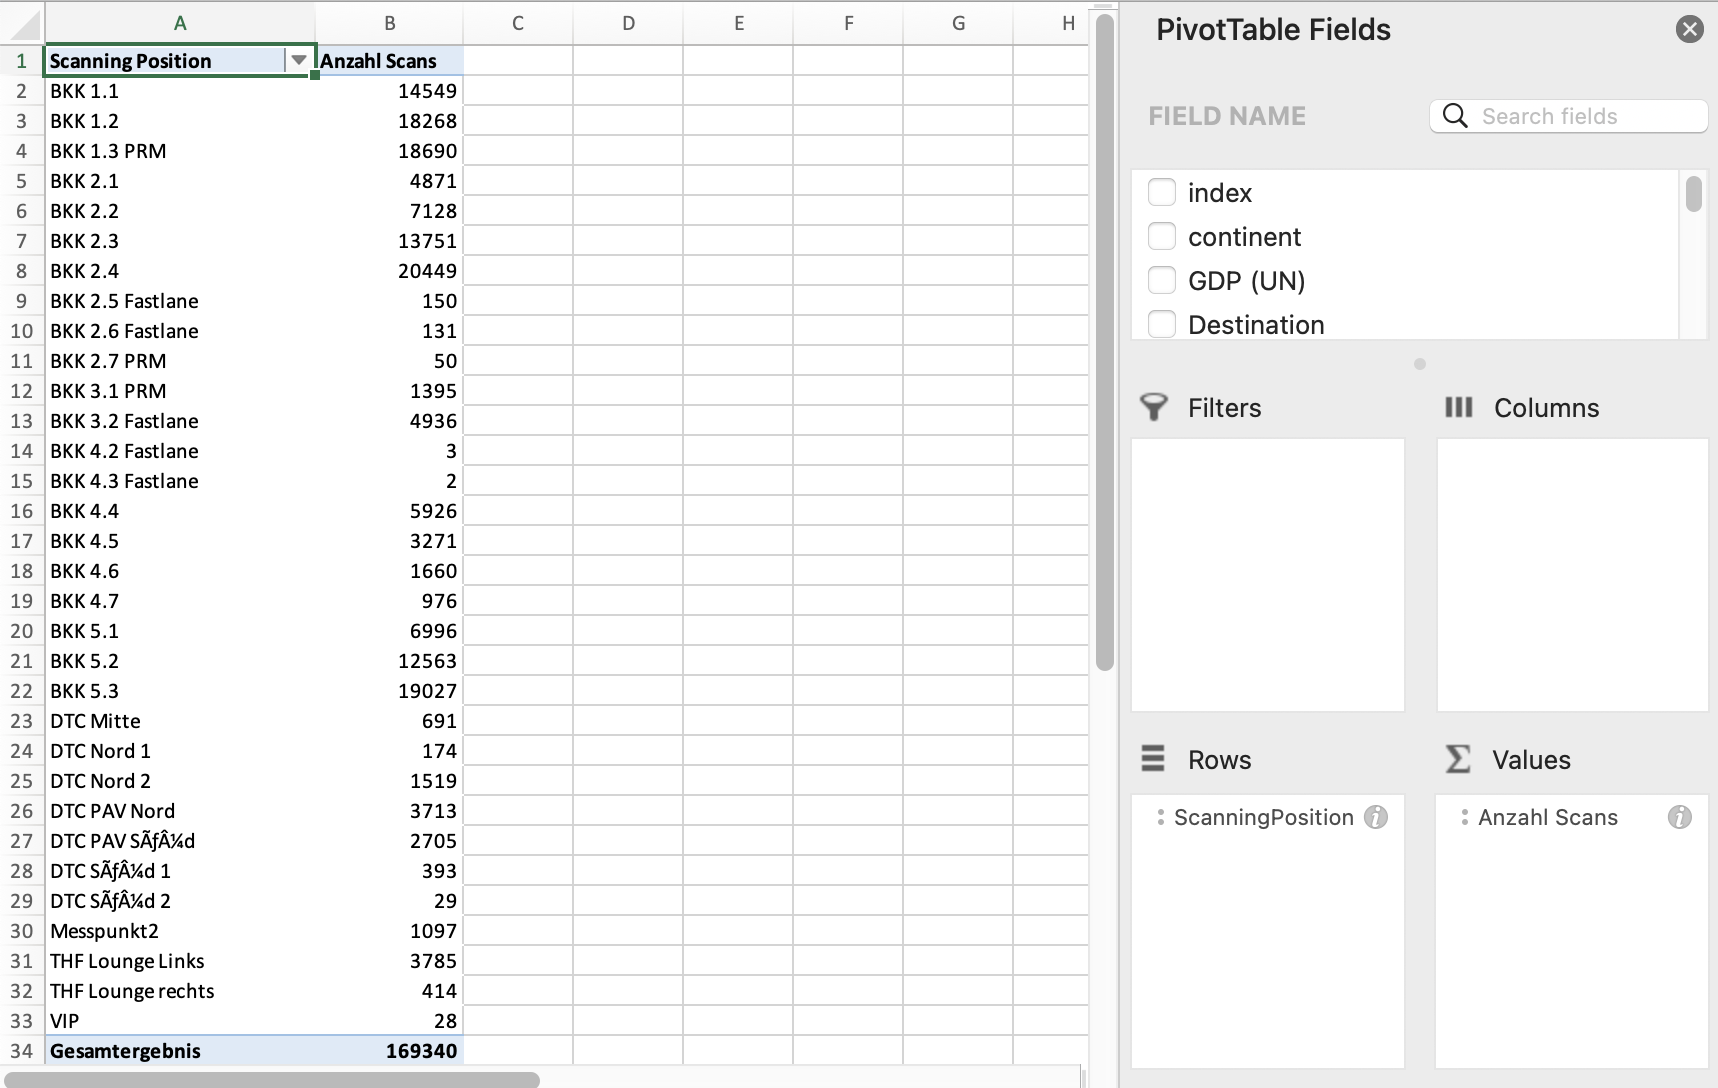

Welche waren die top 5 angeflogenen Städte?

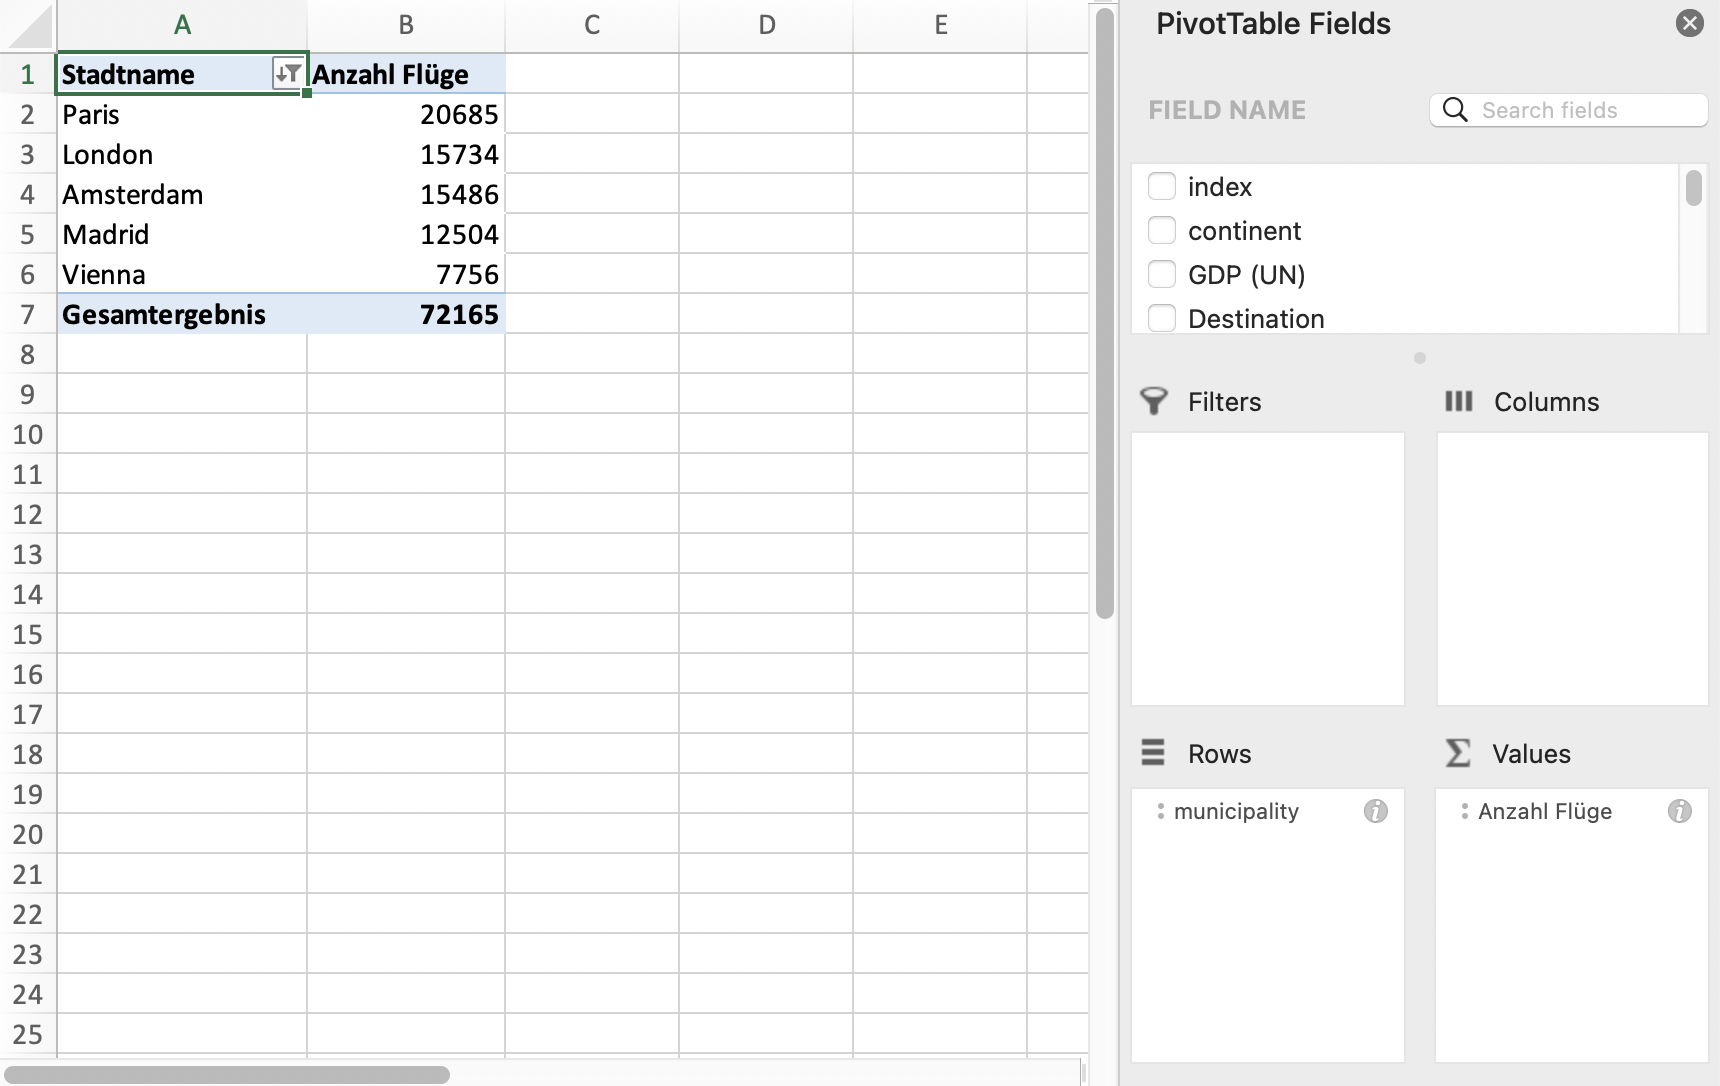

Welche Dokumententypen wurden beim Bordkartenscan wie oft verwendet?

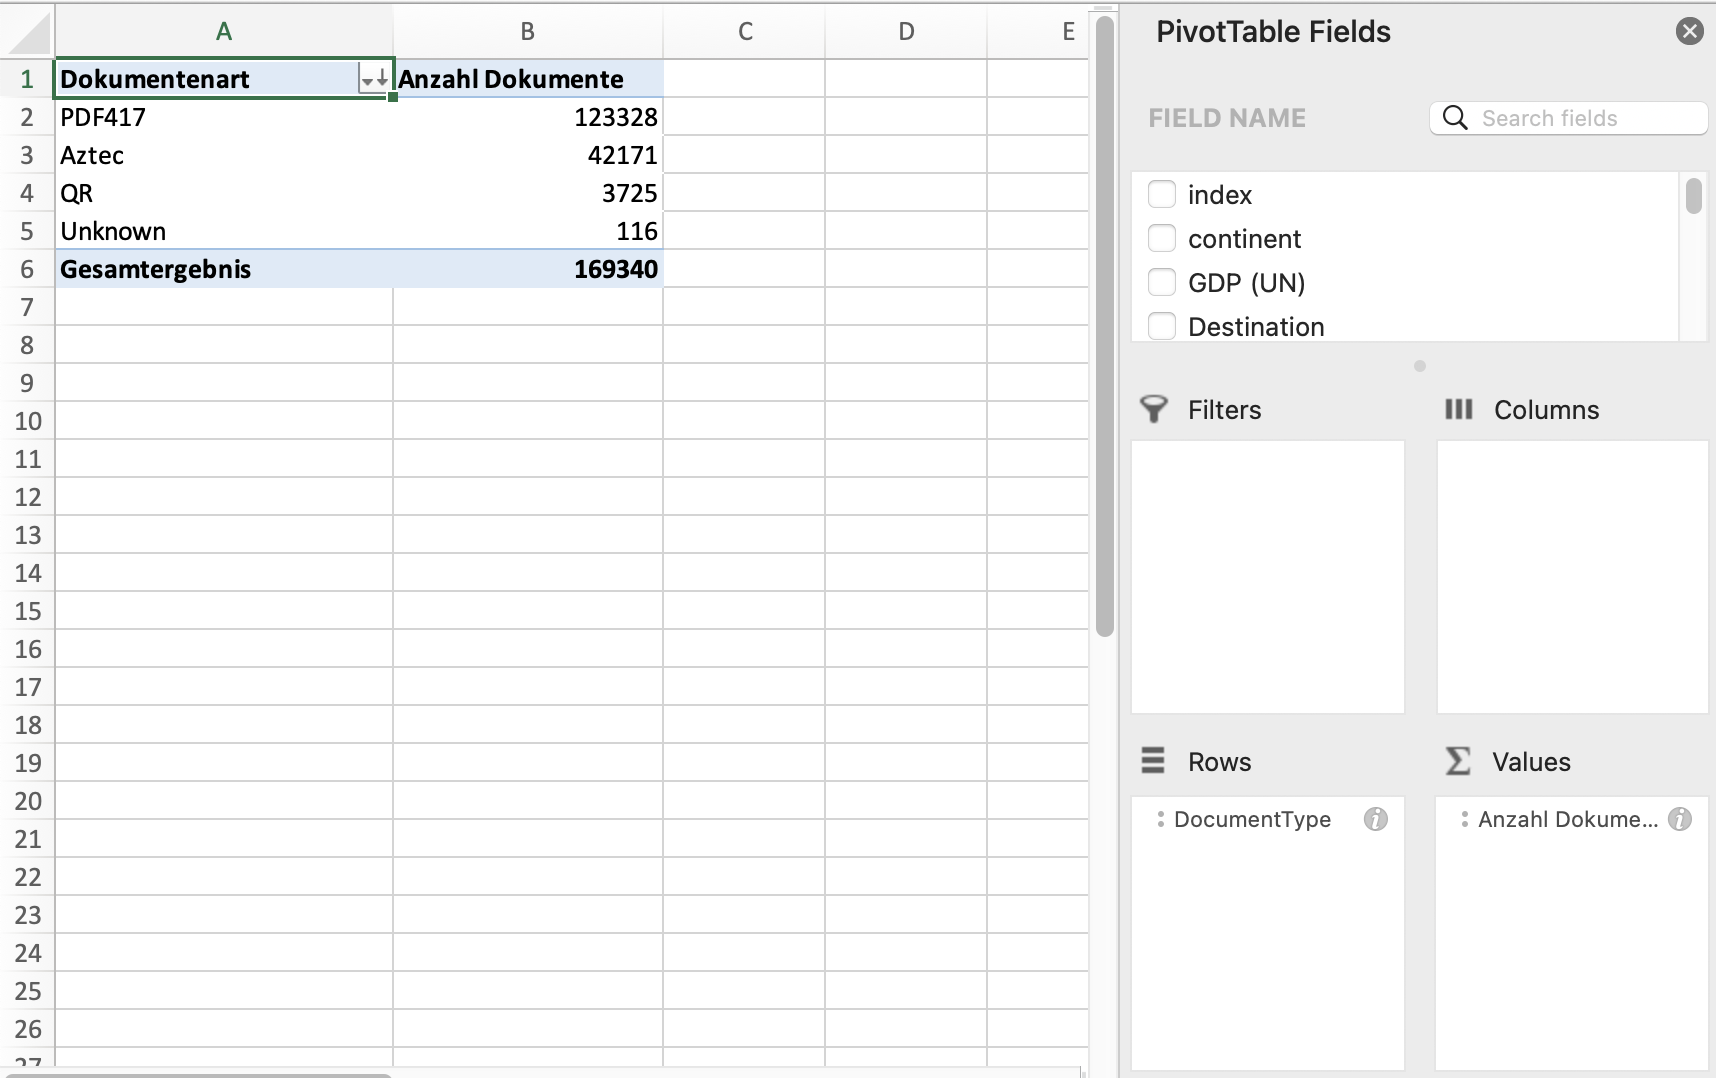

Wie viele Status der Bordkartenscans kamen vor?

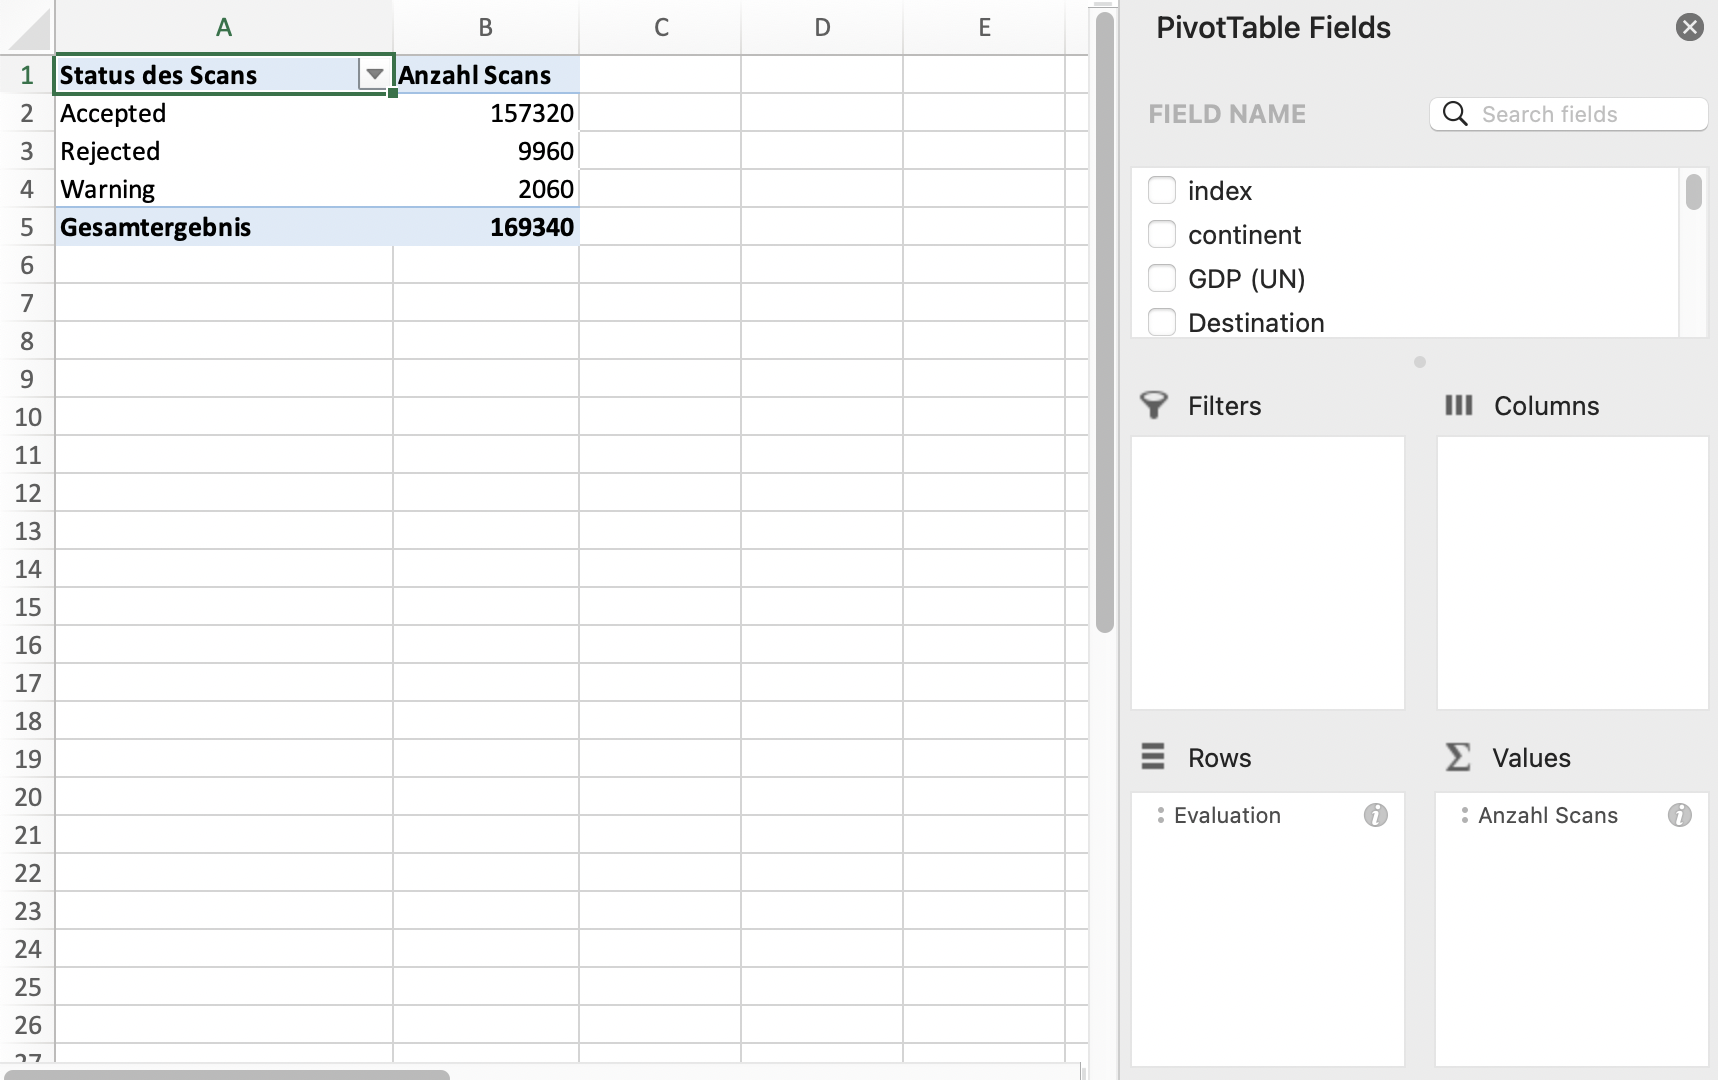

#### Pivot-Tabellen mit Python

Wie viele Bordkartenscans wurden von welcher Sicherheitskontrollspur durchgeführt?

In [44]:
df_pivot_AnzahlScans = pd.pivot_table(df_joinedData, values=['continent'], index=['ScanningPosition'], aggfunc='count') 
df_pivot_AnzahlScans = df_pivot_AnzahlScans.rename(columns={'continent': 'Anzahl Scans'})
df_pivot_AnzahlScans

,Anzahl Scans
ScanningPosition,
BKK 1.1,14546
BKK 1.2,18263
BKK 1.3 PRM,18683
BKK 2.1,4866
BKK 2.2,7120
BKK 2.3,13737
BKK 2.4,20443
BKK 2.5 Fastlane,150
BKK 2.6 Fastlane,131


Welche Dokumententypen wurden beim Bordkartenscan wie oft verwendet?

In [45]:
df_pivot_DokumentenArt = pd.pivot_table(df_joinedData, values=['Terminal'], index=['DocumentType'], aggfunc='count') 
df_pivot_DokumentenArt = df_pivot_DokumentenArt.sort_values(by='Terminal', ascending = False)
df_pivot_DokumentenArt = df_pivot_DokumentenArt.rename(columns={'Terminal': 'Anzahl gescannte Dokumente'})
df_pivot_DokumentenArt

,Anzahl gescannte Dokumente
DocumentType,
PDF417,123328
Aztec,42171
QR,3725
Unknown,116


Welche waren die top 5 angeflogenen Städte?

In [48]:
df_pivot_Stadt = pd.pivot_table(df_joinedData, values=['Terminal'], index=['municipality'], aggfunc='count')
df_pivot_Stadt = df_pivot_Stadt.sort_values(by='Terminal', ascending = False)
df_pivot_Stadt = df_pivot_Stadt.rename(columns={'Terminal': 'Anzahl Flüge'})
df_pivot_Stadt.head()

,Anzahl Flüge
municipality,
Paris,20685
London,15734
Amsterdam,15486
Madrid,12504
Vienna,7756


Wie viele Status der Bordkartenscans kamen vor?

In [50]:
df_pivot_ScanStatus = pd.pivot_table(df_joinedData, values=['Terminal'], index=['Evaluation'], aggfunc='count') 
df_pivot_ScanStatus = df_pivot_ScanStatus.rename(columns={'Terminal': 'Anzahl der Status'})
df_pivot_ScanStatus

,Anzahl der Status
Evaluation,
Accepted,157320
Rejected,9960
Warning,2060


## Abschluss

> Vielen Dank, dass Du bis hierhin durchgehalten hast. <br>
> <u>@Sebastian</u>: Vielen Dank für das Wissen und für die spannenden insights! <br>
> Hier ein Cookie :D
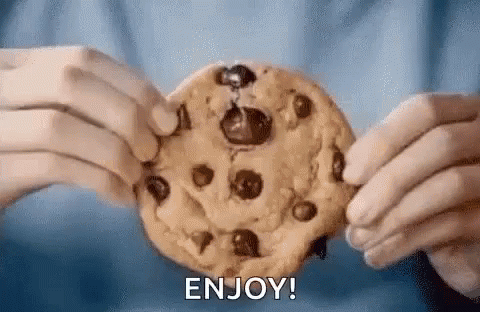